In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import time

# custom functions
from functions import *

import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

2024-11-11 23:29:23.665015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731364163.684468   39365 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731364163.690037   39365 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 23:29:23.707875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/michael/.pyenv/versions/funnypress-data-study/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: 

In [2]:
df = pd.read_csv('../data/clean/dataset.csv').fillna('')

In [3]:
df

,name,url,title,lemmes,funny
0,le_monde,https://www.lemonde.fr/disparitions/article/20...,"Simon Fieschi, grièvement blessé pendant l’att...",simon fieschi grievement blesser attentat cont...,0
1,le_monde,https://www.lemonde.fr/idees/article/2024/10/1...,« Il faut expliquer la différence entre les ef...,falloir expliquer difference effet concret imm...,0
2,le_monde,https://www.lemonde.fr/economie/article/2024/1...,Le périphérique a désormais son outil évaluate...,peripherique outil evaluateur kilometre heure,0
3,le_monde,https://www.lemonde.fr/economie/article/2024/1...,"En Occitanie, les agriculteurs mécontents mult...",occitanie agriculteur mecontent multiplier act...,0
4,le_monde,https://www.lemonde.fr/les-decodeurs/article/2...,Présidentielle américaine 2024 : comment Donal...,presidentielle americain donald trump instrume...,0
...,...,...,...,...,...
102080,ouest_france,https://www.ouest-france.fr/pays-de-la-loire/t...,Le défi Foyers à alimentation positive d’Erd...,defi foyers alimentation positif erdre gesvre ...,0
102081,ouest_france,https://www.ouest-france.fr/sport/football/red...,"Football. Le propriétaire du Red Star, 777 Pa...",football proprietaire red star partners failli...,0
102082,ouest_france,https://www.ouest-france.fr/normandie/lisieux-...,"Plus d’un an après les émeutes à Lisieux, l...",an apres emeute lisieux poste police municipal...,0
102083,ouest_france,https://www.ouest-france.fr/bretagne/finistere...,Le Sud-Finistère célèbre la culture urbaine...,sud finistere celebre culture urbain etat,0


In [4]:
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf
import numpy as np
from tqdm import tqdm

# Load the CamemBERT model and tokenizer
model_name = "camembert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name)

# Example list of 100,000 sentences (replace with your actual data)
sentences = list(df['title'])

# Define batch size for processing
batch_size = 32  # Adjust based on available memory

# Function to extract embeddings for a batch of sentences
def extract_embeddings(batch_sentences):
    # Tokenize and encode the batch of sentences
    inputs = tokenizer(
        batch_sentences, return_tensors="tf", padding=True, truncation=True
    )
    
    # Get model outputs
    outputs = model(**inputs)
    
    # Pool the embeddings by averaging token embeddings
    sentence_embeddings = tf.reduce_mean(outputs.last_hidden_state, axis=1)
    return sentence_embeddings

# Loop through sentences in batches and store the embeddings
all_embeddings = []
num_batches = len(sentences) // batch_size + (len(sentences) % batch_size != 0)

for i in tqdm(range(0, len(sentences), batch_size), total=num_batches, desc="Encoding Batches"):
    batch_sentences = sentences[i:i + batch_size]
    batch_embeddings = extract_embeddings(batch_sentences)
    all_embeddings.append(batch_embeddings)

# Concatenate all batch embeddings into a single tensor
all_embeddings = tf.concat(all_embeddings, axis=0)

# Convert to NumPy array if needed for downstream processing
all_embeddings_np = all_embeddings.numpy()

print("Shape of embeddings:", all_embeddings_np.shape)  # Should be (100000, hidden_size)

I0000 00:00:1731364175.785970   39365 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1731364175.786154   39365 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1730 MB memory:  -> device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCamembertModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFCamembertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassi

Shape of embeddings: (102085, 768)


<Figure size 800x600 with 0 Axes>

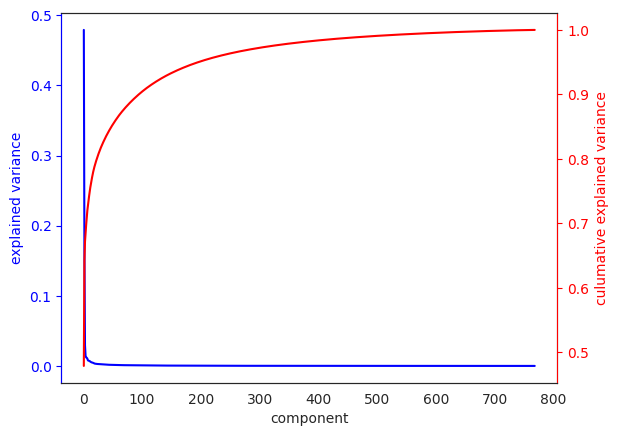

In [6]:
pca_graph(all_embeddings_np)

In [7]:
y = df.funny

In [8]:
mapper = umap.UMAP(n_components=2, n_jobs=-1, verbose=1).fit(all_embeddings_np)    

UMAP( verbose=1)
Mon Nov 11 23:56:23 2024 Construct fuzzy simplicial set
Mon Nov 11 23:56:23 2024 Finding Nearest Neighbors
Mon Nov 11 23:56:23 2024 Building RP forest with 21 trees
Mon Nov 11 23:56:33 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	Stopping threshold met -- exiting after 6 iterations
Mon Nov 11 23:56:53 2024 Finished Nearest Neighbor Search
Mon Nov 11 23:56:57 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Nov 11 23:57:33 2024 Finished embedding


<Axes: >

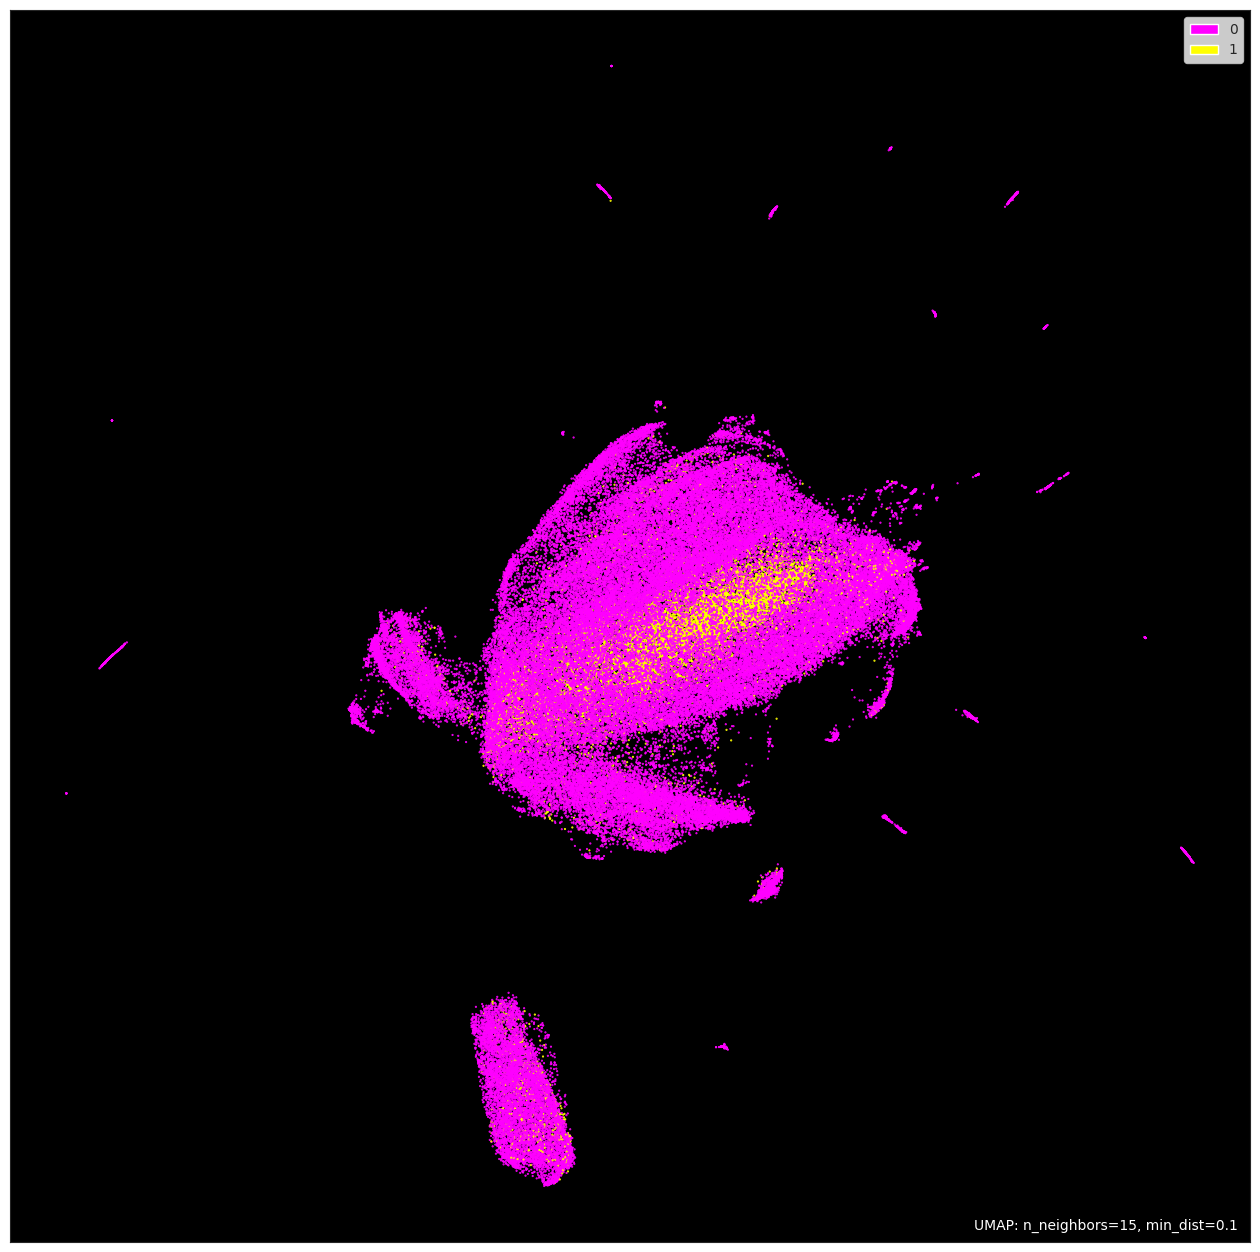

In [9]:
umap.plot.points(mapper, labels=y, background='black', color_key_cmap='spring', width=1600, height=1600)